# Assignment 1 - k-Armed Bandit Problems (28 points)


In this assignment, you will implement different strategies (algorithms) to solve k-Armed Bandit problems, and you will compare and visually analyze their relative performance differences. The maximum number of points for each subtask is indicated next to the sections.

    
Before you start with this problem:
- Study the corresponding slide deck(s) and consider re-watching the lecture recording(s).
- Internalize the material until you feel confident you can work with them or implement them yourself. Only then start working on this assignment; otherwise, you will waste a lot of time.

---


<div class="alert alert-warning">


</div>

## Running code cells

To execute a code cell, use either `Ctrl-Enter`, `Shift-Enter`, or the GUI buttons above.


# Definition of the Problem (Repetition)
k-armed bandit problem definition:
- we repeatedly choose among $k$ different actions
- after each action, we receive a numeric reward
  (originating from a stationary probability distribution, except in the last exercise in this problem set)
- the sole objective: maximize expected total reward over time (by finding and exploiting the most beneficial actions)

The particular **algorithm testbed** we will be using here is defined as follows:
- a set of 2000 randomly generated $10$-armed bandit problems
- for each problem instance, the true action values $q_*(a)$ are sampled from $\mathcal{N}(0,\,1)$ in the beginning
- the actual rewards $R_t$ are sampled from $\mathcal{N}(q_*(a),\,1)$ at each step
- we **don't know** the true action values and hence have to **estimate** them!

## Python Imports & Constants

In [2]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

## Definition of k-Armed Bandit Problem
In this section, we implement the actual bandit problem.

In [3]:
class kArmedBandit():
    """
    Specifies a k-armed bandit problem
    
    The agent has to choose from k different actions.
    Taking an action yields a numeric reward specified
    by a stationary probability distribution.
    """
    
    def __init__(self, k=10, seed=None):
        """
        Parameters
        ----------
            @k: the number of actions / arms / levers of the k-armed bandit
            @seed: the seed of the pseudo random number generator (PRNG) that
                   completely specifies this (random) k-armed bandit problem.
                   if you use 'None' for the seed, numpy will use the entropy
                   pool of the operating system to get some true randomness.
                   in the interest of having reproducible experiments, we should
                   always provide a seed here.
        """
        self.k = k
        self.rng = np.random.default_rng(seed)
        # sample the true action values from a gaussian
        # with mean 0 and standard deviation 1.
        
        # these are the values we **don't know**!
        # we'll never use them directly!
        self.q_star = self.rng.normal(0, 1, k)
        
    
    def step(self, action):
        """
        Take one step, choosing 'action'. This is the **only** method
        that the agent will interact with.
        
        Parameters
        ----------
           @action: action id (integer in [0, k[)
        
        Returns
        -------
            the reward for taking this action.
        """
        # the reward is drawn from a normal distribution with
        # mean q_star[action] and standard deviation 1
        Rt = self.rng.normal(self.q_star[action], 1)
        return Rt
        

## Visualization of one problem instance
This section is <b>just for visualizing</b> the problem instances we are facing.
For this purpose, we generate one instance of the problem and uniformly select actions to get a notion of the underlying stationary probability distribution.

In [4]:
# initialize bandit problem with 10 actions
bandit = kArmedBandit(k=10, seed=1234)

In [5]:
# iterate actions and select each one 1000 times
N_SAMPLES = 1000
action_rewards = np.zeros((N_SAMPLES, bandit.k))
for action in range(bandit.k):
    # choose each action several times and recive reward
    # (this will (hopefully) reveal the underlying distribution)
    for i_sample in range(N_SAMPLES):
        reward = bandit.step(action)
        action_rewards[i_sample, action] = reward
    

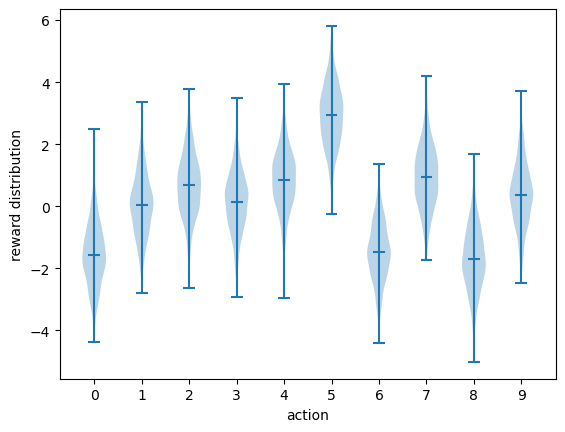

In [6]:
fig, ax = plt.subplots()
ax.violinplot(
    action_rewards,
    np.arange(0, bandit.k),
    showmeans=True,
    showmedians=False,
    showextrema=True
)
ax.set_xlabel('action')
ax.set_xticks(np.arange(0, bandit.k))
ax.set_ylabel('reward distribution')
plt.show()

# Comparison of Standard Algorithms
Your task in this exercise is to compare the bandit algorithms listed below on our standard testbed e.g. the 10-armed bandit problem.
* Iterative Sample Average Method
* Greedy vs. epsilon-Greedy Action Selection
* Optimistic Initial Values
* Upper Confidence Bound Method
* Gradient Bandit Algorithms
* Iterative Sample Average Method with constant step size

## Random Action Selection Baseline
Implementation of a random action selection baseline. This should just serve as a template for you to implement the "much more intelligent" bandit algorithms below.

In [7]:
class RandomBaseline():
    def __init__(self, k=10, seed=None):
        """
        Random Action Selection Baseline
        
        This method simply selects an action at random, and does
        not care about rewards at all.
    
        Parameters
        ----------
            @k: number of possible actions (integer)
            @seed: PRNG seed
        """
        # we should definitely remember how many actions there are
        # in order to make a decision ...
        self.k = k
        
        # all of the random behavior of an agent should depend on a
        # PRNG that is initialized in the constructor, given the seed
        
        # whenever your agent has the need for random numbers,
        # you **must use only this** PRNG!
        self.rng = np.random.default_rng(seed)
    
    def choose_action(self):
        """ Action selection is random """
        # we'll use the PRNG that has been initialized in the constructor
        # to draw a uniformly distributed, random integer from the interval [0, k[
        return self.rng.integers(0, self.k)
    
    def update_estimates(self, action, reward):
        """ Because we behave randomly, we don't need to update anything."""
        pass

## Experimental setup
For comparing the implemented methods, we will create similar <b>time step vs. average reward plots</b> as the ones shown in the lecture slides and the book.

In order to facilitate this comparison, we will define a convenience function to run experiments. This enables us to specify an `agent_class` together with its parameters `agent_args` and then run `n_runs` different instances of the k-armed bandit problem for `n_steps` steps, using `agent_class` to solve the problems.


**Hint:** for debugging purposes, you may want to run a smaller number of runs for a smaller number of steps; to do so, you may change `n_runs` and `n_steps` when calling the function, but ...

<div class="alert alert-warning"> 

    
<b>Please remember to change them back to `n_runs=2000` and `n_steps=1000`, and re-run the entire notebook before submitting!</b>
</div>

In [8]:
def run_experiments(exp_seed,
                    n_runs=2000,
                    n_steps=1000,
                    k=10,
                    bandit_class=kArmedBandit,
                    agent_class=RandomBaseline,
                    agent_args=dict()):
    """
    Run experiments following the policy of the provided agent.
    is
    Parameters
    ----------
    @exp_seed: the seed for the 'mother-PRNG' that produces all other seeds
    @n_runs: number of different bandit problems (integer)
             (to debug your algorithms, you may set this to a lower number.
              don't forget to change it back, once you're done with debugging!)
    @n_steps: number of steps taken in each individual problem (integer)
              (to debug your algorithms, you may set this to a lower number.
              don't forget to change it back, once you're done with debugging!)
    @k: number of actions for the bandit problems (integer)
    @bandit_class: this allows you to change the type of bandit
                   (please only do so for the last problem in this problem set)
    @agent_class: specifies the bandit algorithm to use
    @agent_args: this dictionary of arguments will be passed on
                 to the constructor of the specified bandit algorithm,
                 
                 (with the exception of 'k' and 'seed', as these will be set
                 by the experiment loop)
    
    Returns
    -------
    a numpy array of rewards with shape (n_runs, n_steps), where
    element (i,j) contains the reward in the i-th run, on the j-th step
    """
    # n_runs=1
    # n_steps=1000
    
    args_list = [f'{key}={val}' for key, val in sorted(agent_args.items())]
    args_string = ','.join(args_list)
    print("running {}({})".format(agent_class.__name__, args_string))
    
    # initialize results
    rewards = np.zeros((n_runs, n_steps))

    if isinstance(exp_seed, list):
        exp_seed = exp_seed[0]
    
    # if we're getting entropy, initialize new seed sequence
    if isinstance(exp_seed, int):
        exp_seed_sequence = np.random.SeedSequence(exp_seed)
    elif isinstance(exp_seed, np.random.SeedSequence):
        exp_seed_sequence = exp_seed
    else:
        raise ValueError('please provide SeedSequence or int!')
    
    # perform multiple runs
    for run in range(n_runs):
        # split off 2 new seeds, one for the agent, one for the bandit
        agent_seed, bandit_seed = exp_seed_sequence.spawn(2)

        # instantiate agent, pass it its arguments
        agent = agent_class(k=k, seed=agent_seed, **agent_args)
        
        # get new instance of problem, with new seed
        bandit = bandit_class(k=k, seed=bandit_seed)

        # perform multiple steps on problem instance
        for step in range(n_steps):

            # let the agent pick an action according to its selection strategy
            action = agent.choose_action()

            # the bandit is told the action that the agent chose, and gives out a reward
            reward = bandit.step(action)

            # the agent is told what the reward was for choosing the action
            agent.update_estimates(action, reward)

            # we will record all rewards for later analysis
            rewards[run, step] = reward
    
    print("done!")
    return rewards

### Example Experiments, Random Action Selection
Lets see how well our random action selection baseline performs, and run one experiment.

In [9]:
# run experiments
rewards_random = run_experiments(exp_seed=1234, agent_class=RandomBaseline)

running RandomBaseline()
done!


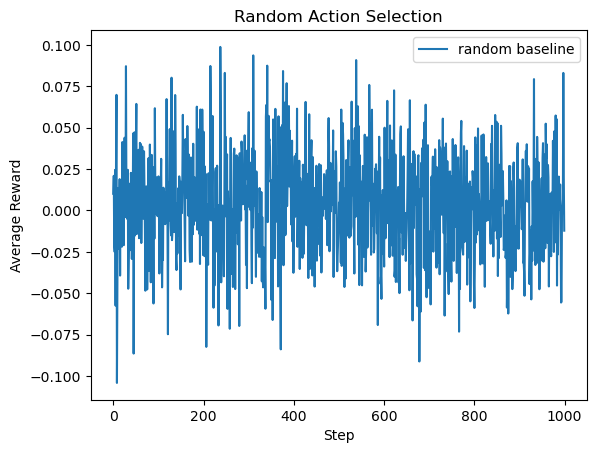

In [10]:
# visualize results
fig, ax = plt.subplots()
ax.plot(
    rewards_random.mean(axis=0),  # average over all runs
    label='random baseline'       # choose a name
)
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
ax.set_title("Random Action Selection")
plt.show()

### Run multiple example experiments, collect results
Let's see how we can run multiple experiments, with different parameters.

In [11]:
# for consecutive experiments, having a so-called 'seed sequence', is
# extremely convenient. also look it up in the documentation, to see
# why this is a "really good idea(tm)"!
exp_seed_sequence = np.random.SeedSequence(4711)

# it's convenient to store the experiments in a
# dictionary, so we can iterate over them more easily later on
all_rewards = dict()
all_rewards['algo A, params X, Y, ...'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=RandomBaseline
)
all_rewards['algo B, params U, V, ...'] = run_experiments(
    exp_seed=exp_seed_sequence,
    agent_class=RandomBaseline
)

# (the algorithms in this example have the same parameters
# but b/c they're completely random anyways, it does not matter)

running RandomBaseline()
done!
running RandomBaseline()
done!


### Visualize multiple results in one plot

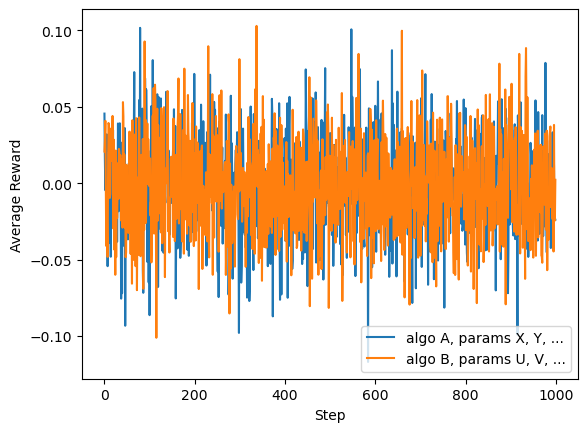

In [12]:
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over axis=0, meaning 'over all runs'
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

---
## 1.1 Incremental Sample Average Method (5 points)

<div class="alert alert-warning"> 
Implementation of the Sample Average Method (ISAM). The algorithm is parametrized by the number of actions and a probability $\epsilon$ of picking a random action instead of following the policy. Use the optional parameter `initial_value` to implement the "Optimistic Initial Values" trick that encourages exploration.
 </div>

In [13]:
class IncrementalSampleAverageMethod():
    def __init__(self, k=10, epsilon=0.0, initial_value=0.0, seed=None):
        """
        Incremental Implementation of the "Sample Average Method"

        Parameters
        ----------
            @k: number of possible actions (integer)
            @epsilon: probability for selecting a random action (float in the interval [0, 1])
            @initial_value: initial action value estimate (should be used for Optimistic Initial Values)
            @seed: the PRNG seed. the PRNG will help us to decide when to explore and when to exploit
        """
        self.k = k
        self.epsilon = epsilon
        
        # initialize an array with our initial estimates
        self.Q = None
        # YOUR CODE HERE
        self.Q = np.full(k, initial_value, dtype=float)
        
        # initialize an array with the action counts
        self.N = None
        # YOUR CODE HERE
        self.N = np.zeros(k, dtype=int)
        
        # seed the PRNG
        self.rng = np.random.default_rng(seed)
        
    def choose_action(self):
        """ Action selection """
        action = None
        # YOUR CODE HERE
        if self.rng.uniform(0, 1) < self.epsilon:
            action = self.rng.integers(0, self.k)
        else:
            action = np.argmax(self.Q)
        return action
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        self.N[action] += 1
        # Q_n = Q_{n-1} + (1 / N) * (reward - Q_{n-1})
        self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])
      

In [14]:
isam = IncrementalSampleAverageMethod()

assert isam.Q is not None, "estimates are not initialized"
assert isam.N is not None, "action counts are not initialized"

In [15]:
isam = IncrementalSampleAverageMethod()

assert isam.choose_action() is not None, "choose_action not implemented!"

In [16]:
# DO NOT DELETE THIS CELL!

## 1.2 Greedy vs. $\epsilon$-Greedy (2 points)

In our first experiment, we will explore the influence of the random action selection probability $\epsilon$ on the average reward we get over time.

<div class="alert alert-warning"> 
For this purpose:
<br> - run the *IncrementalSampleAverageMethod* (ISAM) three times with $\epsilon \in \{0.0, 0.01, 0.1\}$.
<br> - collect the rewards that could be achieved for each parametrization, and plot their means in one plot for comparison.
<br> - answer the questions below
</div>

In [17]:
# run experiments
epsilons = [0., 0.01, 0.1]
exp_seed_sequence = np.random.SeedSequence(1234)

# store the reward squences into this dictionary
all_rewards = {
    'ISAM (purely greedy)': None,
    'ISAM (epsilon = 0.01)': None,
    'ISAM (epsilon = 0.1)': None
}

# use run_experiments to collect the rewards
# run help(run_experiments) to see the function's parameters

# YOUR CODE HERE
for epsilon in epsilons:
    if epsilon == 0.0:
        label = 'ISAM (purely greedy)'
    elif epsilon == 0.01:
        label = 'ISAM (epsilon = 0.01)'
    else:
        label = 'ISAM (epsilon = 0.1)'
    rewards = run_experiments(
        exp_seed=exp_seed_sequence,           
        n_runs=2000,                          
        n_steps=1000,                         
        k=10,                                 
        bandit_class=kArmedBandit,            
        agent_class=IncrementalSampleAverageMethod,  
        agent_args={'epsilon': epsilon}       
    )

    all_rewards[label] = rewards


running IncrementalSampleAverageMethod(epsilon=0.0)
done!
running IncrementalSampleAverageMethod(epsilon=0.01)
done!
running IncrementalSampleAverageMethod(epsilon=0.1)
done!


In [18]:
assert all([r is not None for i, r in all_rewards.items()]), "Store the reward squences into the all rewards dictionary."

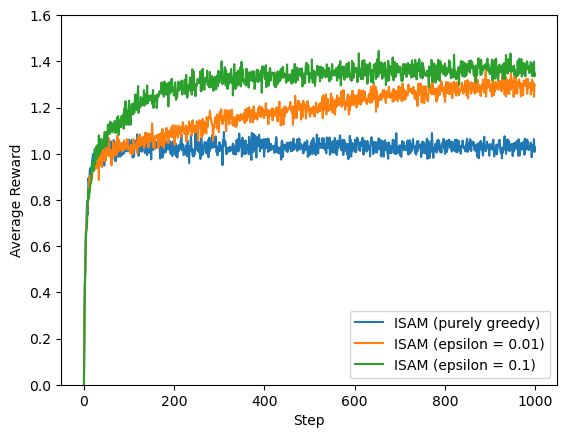

In [19]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

Answere the following question
- On average, how often will 'ISAM ($\epsilon = 0.05$)' select the greedy move if $k=10$, i.e., what is the probability of selecting a greedy action if $\epsilon=0.05$?

In [28]:
# store the result into this variable (don't forget to remove the error statement)
p_greedy = None

# YOUR CODE HERE
p_greedy = 0.95 + 0.05 * (1/10)

In [29]:
assert 0 <= p_greedy and p_greedy <= 1, 'Probabilities must be inbetween 0 and 1.'

## 1.3 Greedy vs. Optimistic Initial Values (2 points)
In our second experiment, we evaluate the performance of another approach to encourage exploration, namely Optimistic Initial Values.

<div class="alert alert-warning"> 
For this purpose
<br>- run IncrementalSampleAverageMethod with an appropriate initial value for all actions and $\epsilon=0$
<br>- and compare its performance with the *IncrementalSampleAverageMethod* with an initial value of $0$ and $\epsilon=0$
<br>- finally, answer the following questions
</div>

In [24]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(1234)

all_rewards = {
    'ISAM (purely greedy)': run_experiments(
        exp_seed=exp_seed_sequence,
        agent_class=IncrementalSampleAverageMethod,
        agent_args={'epsilon': 0.0}
    ),
    'ISAM (epsilon = 0.01)': run_experiments(
        exp_seed=exp_seed_sequence,
        agent_class=IncrementalSampleAverageMethod,
        agent_args={'epsilon': 0.01}
    ),
    'ISAM (epsilon = 0.1)': run_experiments(
        exp_seed=exp_seed_sequence,
        agent_class=IncrementalSampleAverageMethod,
        agent_args={'epsilon': 0.1}
    )
}



running IncrementalSampleAverageMethod(epsilon=0.0)
done!
running IncrementalSampleAverageMethod(epsilon=0.01)
done!
running IncrementalSampleAverageMethod(epsilon=0.1)
done!


In [25]:
assert all([r is not None for i, r in all_rewards.items()]), "Store the reward squences into the all rewards dictionary."

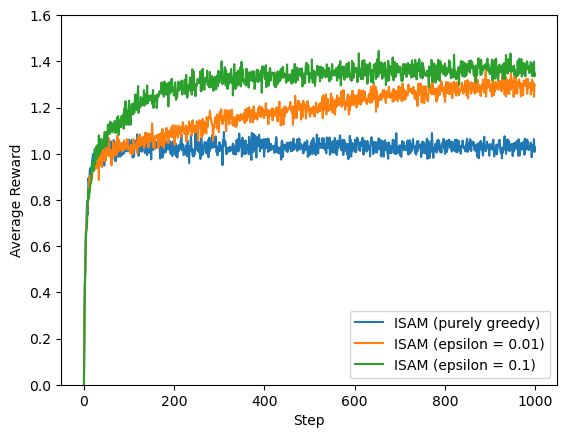

In [26]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

Is the following statement correct?
- Encouraging expolration with OIV also works with high negative initial values.

In [27]:
# store True or False
OIV_init = None

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [ ]:
assert OIV_init is not None, 'Store True/ False!'
assert OIV_init in [True, False], 'Invalid answer!'

## 2.1 Upper Confidence Bound Action Selection (5 points)

<div class="alert alert-warning"> 
Implement the Upper Confidence Bound Action Selection Method. The algorithm is parametrized by the number of actions and a value $c > 0$ to control the degree of exploration. 
</div>

**Important**: In case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence must be returned (default behaviour of `np.argmax`).

**Hint:** In case you encounter a division by 0 error, take a closer look at the values for $t$ and $N_t(a)$.
Note that if $N_t(a) = 0$, then $a$ is considererd to be a greedy (maximizing) action.

In [ ]:
class UpperConfidenceBound():
    def __init__(self, k=10, c=0.0, seed=None):
        self.k = k
        self.c = c
        
        # Initialize estimates and counts to zero
        self.Q = np.zeros(k)  
        self.N = np.zeros(k)
        self.total_steps = 0
        
    def choose_action(self):
        self.total_steps += 1
        
        # If any action hasn't been tried yet, it should be tried first
        if np.any(self.N == 0):
            return np.where(self.N == 0)[0][0]
            
        # Calculate UCB values for each action
        ucb_values = self.Q + self.c * np.sqrt(np.log(self.total_steps) / self.N)
        return np.argmax(ucb_values)
    
    def update_estimates(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (1/self.N[action]) * (reward - self.Q[action])


In [ ]:
ucb = UpperConfidenceBound()

assert ucb.Q is not None, "value function not initialized"
assert ucb.N is not None, "action counter not initialized"

In [ ]:
ucb = UpperConfidenceBound()

assert ucb.choose_action() is not None, "choose_action not implemented!"

In [ ]:
# DO NOT DELETE THIS CELL!

## 2.2 $\epsilon$-Greedy vs Upper Confidence Bound Action Selection (2 points)
In our next experiment we compare $\epsilon$-greedy action selection with the *UCB* action selection algorithm.

<div class="alert alert-warning"> 
For this purpose:
<br>- run the *UCB* action selection algorithm with exploration parameter $c=2$
<br>- and compare its performance with the *IncrementalSampleAverageMethod* and $\epsilon=0.1$
<br>- answer the following questions
</div>

In [ ]:
exp_seed_sequence = np.random.SeedSequence(1234)

# run experiments
all_rewards = {
    '$\epsilon$ = 0.1': None,
    'UCB(c=2)': None
}

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert all([r is not None for i, r in all_rewards.items()]), "Store the reward squences into the all rewards dictionary."

In [ ]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

The previous figure shows a distinct spike of UCB (orange) at step 11.

Is the following statement correct?
-  This spike would be less prominent if a higher value was chosen for $c$, e.g., $c=3$.

In [ ]:
# store True or False
UCB_spike = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert UCB_spike is not None, 'Store True/ False!'
assert UCB_spike in [True, False], 'Invalid answer!'

## 3.1 Gradient Bandit Algorithm (5 points)

<div class="alert alert-warning"> 
Implement the Gradient Bandit Algorithm with baseline. The algorithm is parametrized by the number of actions and step size $\alpha$.
</div>

In [ ]:
class GradientBandit():
    def __init__(self, k=10, alpha=0.1, seed=None):
        """
        Gradient Bandit Action Selection Method

        Parameters
        ----------
            @k: number of possible actions (integer)
            @alpha: step-size parameter, or learn rate (float)
            @seed: the PRNG seed. it'll be used to sample from the softmax distribution.
        """ 
        self.k = k
        self.alpha = alpha
        self.rng = np.random.default_rng(seed)

        # initialize action selection preferences, baseline and step
        self.H = None
        self.baseline = None
        self.step = None
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def choose_action(self):
        """ Action selection """
        # choose action according to preference
        At = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return At
    
    def update_estimates(self, action, reward):
        """ update step count and action selection preferences """
        # update baseline and
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
gb = GradientBandit()

assert gb.H is not None, "prferences not initialized"
assert gb.baseline is not None, "baseline not initialized"
assert gb.step is not None, "step not initialized"

In [ ]:
gb = GradientBandit()

assert gb.choose_action() is not None, "choose_action not implemented!"

In [ ]:
# DO NOT DELETE THIS CELL!

## 3.2 $\epsilon$-Greedy vs Gradient Bandit (2 points)
In our last experiment we compare $\epsilon$-greedy action selection with the *GradientBandit* algorithm.

<div class="alert alert-warning"> 
For this purpose:
<br>- run the *GradientBandit* algorithm with step sizes $\alpha=0.01$ and $0.1$.
<br>- and compare its performance with the *IncrementalSampleAverageMethod* and $\epsilon=0.1$.
<br>- answer the following question
</div>

In [ ]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(1234)

all_rewards = {
    'GB(alpha = 0.01)': None,
    'GB(alpha = 0.1)': None,
    'ISAM(epsilon = 0.1)': None
}

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert all([r is not None for i, r in all_rewards.items()]), "Store the reward squences into the all rewards dictionary."

In [ ]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

Is the following statement correct?
- Action selection preferences (H) are directly correltated with the expected reward of actions.

In [ ]:
# store True or False
gradient_bandit_action_selection_preferences = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert gradient_bandit_action_selection_preferences is not None, 'Store True/ False!'
assert gradient_bandit_action_selection_preferences in [True, False], 'Invalid answer!'

# 4. Tracking non-stationary problems (5 points)
Sample-average methods have difficulties with <b>non-stationary</b> problems. We will use a <b>modified</b> version of the 10-armed bandit, in which all the $q_{\star}(a)$ start out equal and then take independent random walks. This is implemented already below.

<div class="alert alert-warning"> 
You just need to create a <b>modified version</b> of the Incremental Sample Average Method that is able to deal with non-stationary problems.

You will need to run separate experiments for:
- an action-value method using sample averages, incrementally computed by $\alpha=\frac{1}{n}$ (you have that already)
- another action-value method that uses a constant step-size parameter, $\alpha=0.1$ (you still need to create that)

Use an $\epsilon=0.1$ for both methods, and then briefly describe the behavior of the two algorithms.

(this is very similar to Exercise 2.5 from the book)
</div>

In [ ]:
class NonstationaryKArmedBandit():
    def __init__(self, k=10, seed=None):
        self.k = k
        self.rng = np.random.default_rng(seed)
        # for the non-stationary bandit problem, all true action
        # values will start out equal
        self.q_star = np.zeros(k)
    
    def step(self, action):
        # but the true value will move around randomly this time
        self.q_star += self.rng.normal(0, 0.01, self.k)
        Rt = self.rng.normal(self.q_star[action], 1)
        return Rt

In [ ]:
class ISAM_cs():
    def __init__(self, k=10, epsilon=0.0, initial_value=0.0, alpha=0.1, seed=None):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha

        # initialize an array with our initial estimates
        self.Q = None
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # seed the PRNG
        self.rng = np.random.default_rng(seed)
        
    def choose_action(self):
        """ Action selection """
        action = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return action
    
    def update_estimates(self, action, reward):
        """ Update action value estimate """
        # YOUR CODE HERE
        raise NotImplementedError()
        pass

In [ ]:
isam_cs = ISAM_cs()

assert isam_cs.Q is not None, "value function not initialized"

In [ ]:
isam_cs = ISAM_cs()

assert isam_cs.choose_action() is not None, "choose_action is not implemented!"

In [ ]:
# DO NOT DELETE THIS CELL!

In [ ]:
# run experiments
exp_seed_sequence = np.random.SeedSequence(4711)

all_rewards = {
    'ISAM(epsilon=0.1)': None,
    'ISAM_cs(epsilon=0.1)': None
    
}
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert all([r is not None for i, r in all_rewards.items()]), "Store the reward squences into the all rewards dictionary."

In [ ]:
# visualize results
fig, ax = plt.subplots()

for label, rewards in all_rewards.items():
    ax.plot(
        rewards.mean(axis=0),  # average over all runs
        label=label
    )
# ax.set_ylim([0.0, 1.6])
ax.legend(loc='best')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Step")
plt.show()

Anser the following Question:
- Which of the implemented methods are suitable for non-stationary problems?

In [ ]:
# store True/ False for each item in the dictionary and remove the raise error statement
suitable_for_nonstationary_problems = {
    'ISAM': None,
    'ISAM_with_constant_alpha': None,
    'UCB': None,
    'OIV': None
}

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert all([r is not None for i, r in suitable_for_nonstationary_problems.items()]), "Store True or False for each item in the dictionary!"
assert all([r in [True, False] for i, r in suitable_for_nonstationary_problems.items()]), "Store True or False for each item in the dictionary!"